In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize as scmin

In [2]:
# Make a portfolio from MSFT TSLA with random weights
stocks = input('Ticker: ').split()  # Input is tickers of stocks
weights = np.array(input('Weights: ').split(), dtype=float)  # You can type in weights based on your portfolio
if weights.size == 0:
    weights = np.random.random(len(stocks))  # Or you can continue with random weights
    weights /= np.sum(weights)
    weights = np.around(weights, 2)

In [3]:
def GetData(stock, time):  # Downloads historical stock prices from yahoofinance and does basic statistical calculations
    hist = yf.download(tickers=stock, period=time, interval='1d', auto_adjust=True, ignore_tz=True)['Close']
    dailyreturns = np.log(hist / hist.shift(1)).dropna()  # Daily log returns
    meanreturn = dailyreturns.mean()
    covmatrix = dailyreturns.cov()  # Covariance matrix
    Returns = np.log((hist.tail(1).iloc[0] - hist.head(1).iloc[0]) / hist.head(1).iloc[0])  # Return of the stocks from
    return meanreturn, covmatrix  # Output is an array of arrays

oneyeardata = GetData(stocks, '1y')
meanreturn = oneyeardata[0]
covmatrix = oneyeardata[1]

meanreturn, covmatrix

[*********************100%***********************]  2 of 2 completed


C:\Users\Pinter Andrea\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(MSFT    0.000827
 TSLA   -0.000993
 dtype: float64,
          MSFT      TSLA
 MSFT  0.00016  0.000120
 TSLA  0.00012  0.001157)

In [4]:
def PortPerformance(weights, returns, covmatrix):  # Calculates performance of the portfolio, such as
    Return = np.sum(weights * returns)*252  # yearly mean return
    stdev = np.sqrt(np.dot(weights.T, np.dot(covmatrix, weights)))*np.sqrt(252) # Standard deviation of portfolio
    return Return, stdev  # Output is an array of values

def portReturn(weights, returns, covmatrix):
    return PortPerformance(weights,returns,covmatrix)[0]

def portVariance(weights, returns, covmatrix):
    return PortPerformance(weights,returns,covmatrix)[1] # Standard deviation of portfolio

portdata = PortPerformance(weights, meanreturn, covmatrix)
portdata

(-0.02089909072940345, 0.31324622133214414)

In [5]:
# We use SLSQP Algorithm for Sharpe-ratio optimization
def negSharpeRatio(weights, returns, covmatrix, riskfreerate = 0):
    portreturn, stdev= PortPerformance(weights,returns,covmatrix)
    return -(portreturn-riskfreerate)/stdev

def maxSharpeRatio(returns, covmatrix, riskfreerate = 0):
    constraint_set=(0,1)
    numofAssets=len(returns)
    maxsp=scmin(fun=negSharpeRatio, x0=weights,args=(returns,covmatrix,riskfreerate),
                bounds=tuple(constraint_set for asset in range(numofAssets)),
                constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}), method='SLSQP')
    return maxsp

maxSharpeRatio(meanreturn, covmatrix)

     fun: -1.0377314951345857
     jac: array([-0.        ,  2.02430195])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1.00000000e+00, 5.55111512e-17])

In [6]:
def minPortfolioVariance(returns, covmatrix):
    constraint_set = (0, 1)
    numofAssets = len(returns)
    minvar = scmin(fun=portVariance, x0=weights, args=(returns, covmatrix),
                  bounds=tuple(constraint_set for asset in range(numofAssets)),
                  constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}), method='SLSQP')
    return minvar

minPortfolioVariance(meanreturn, covmatrix)

     fun: 0.19996307353582268
     jac: array([0.19996434, 0.19993026])
 message: 'Optimization terminated successfully'
    nfev: 15
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.96287575, 0.03712425])

In [8]:
def OptimalPortfolio(returns, covmatrix, targetreturn):
    constraint_set = (0, 1)
    numofAssets = len(returns)
    constraint = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                     {'type': 'eq', 'fun': lambda x: portReturn(x,returns,covmatrix)-targetreturn})
    minvar = scmin(fun=portVariance, x0=weights, args=(returns, covmatrix),
                   bounds=tuple(constraint_set for asset in range(numofAssets)),
                   constraints=constraint, method='SLSQP')
    return minvar

OptimalPortfolio(meanreturn, covmatrix, 0.2)

     fun: 0.20019946007907732
     jac: array([0.20066714, 0.17535925])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.98152049, 0.01847951])

[*********************100%***********************]  2 of 2 completed


C:\Users\Pinter Andrea\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


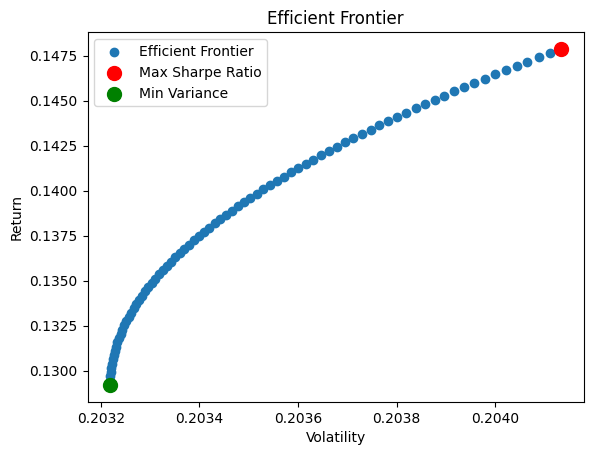

In [9]:
ret, covmat = GetData(stocks,'ytd')

maxSRret, maxSRvar = PortPerformance(maxSharpeRatio(ret,covmat).x,ret,covmat)
minVarret, minVarvar= PortPerformance(minPortfolioVariance(ret,covmat).x, ret, covmat)
targetreturns=np.linspace(minVarret,maxSRret,80)
efficientList = []
for target in targetreturns:
    data=[target,OptimalPortfolio(ret, covmat, target).fun]
    efficientList.append(data)

frontier=pd.DataFrame(efficientList,columns=['Return','Volatility'])
plt.scatter(x=frontier['Volatility'],y=frontier['Return'])
plt.scatter(x=maxSRvar,y=maxSRret,c='red',marker='o',s=100)
plt.scatter(x=minVarvar,y=minVarret,c='green',marker='o',s=100)
plt.legend(['Efficient Frontier','Max Sharpe Ratio','Min Variance'])
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')

plt.show()